## 1. Load CityGML and TEASERPLUS project

In [1]:
import os
import pickle
from pathlib import Path
import geopandas as gpd
from dhc_sim.processing import GMLProcessor, NetworkProcessor
from dhc_sim.utils import *

# Get current working directory
current_dir = os.getcwd()

# Set path to pickle file of TEASERPLUS project class
pickle_file = os.path.join(current_dir, "output", "demo_teaser_pickle.p")

# Load TEASERPLUS project class
prj = pickle.load(open(pickle_file, "rb"))

# Set path to gml file
gml_path = os.path.join(current_dir, 'data', 'citygml_files', 'citydb_export.gml')

# Create GMLProcessor class
gml = GMLProcessor(gml_path)

# Extract building elements from gml file
buildings = gml.get_buildings()

# Get namespaces of gml file
namespaces = gml.namespaces

# Get CRS of gml file
crs = gml.source_crs

# Create GeoDataFrame from building elements containing id, name, xml, footprint, centroid
gdf = create_gdf_from_buildings(buildings, namespaces, crs)

# Rename building names to match TEASERPLUS
gdf['name'] = gdf['name'].apply(convert_bldg_name_to_teaser_bldg_name)

# Check if building names match
compare_building_names(prj, gdf)

Found 36 matching buildings out of 36 project buildings


## 2. Get polygon coordinates for area of interest from QGIS

**Use QGIS field calculator:**
>```python
>geom_to_wkt($geometry)
>```

**Output:**
>MultiPolygon (((1818711.45449641 6145714.52793876, 1818896.19119223 6145696.76479493, 1819169.03308143 6145675.44902233, 1819119.29627871 6145502.79126432, 1819080.21736229 6145357.84401069, 1818892.90839519 6145442.25652424, 1818707.1913419 6145519.8438824, 1818707.1913419 6145519.8438824, 1818711.45449641 6145714.52793876)))

## 3. Create street network and add building access nodes

c:\Users\dawo\anaconda3\envs\dhc_sim_env\Lib\site-packages\osmnx\convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])


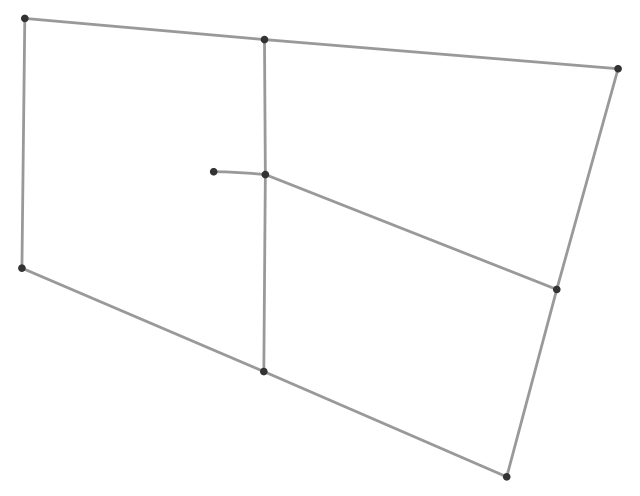

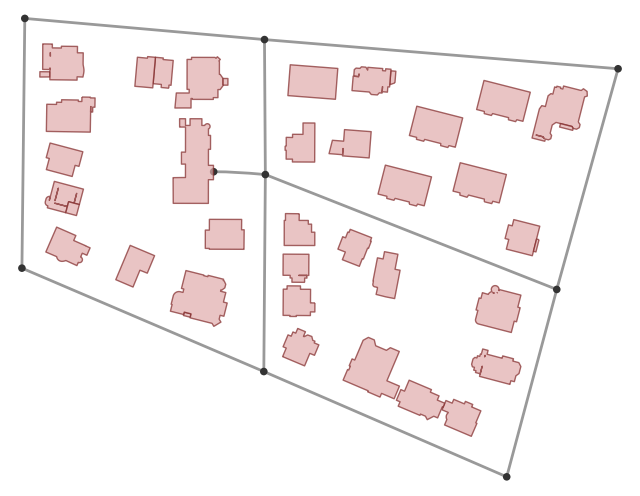

In [2]:
# WKT string of area of interest
wkt = "MultiPolygon (((1818711.45449641 6145714.52793876, 1818896.19119223 6145696.76479493, 1819169.03308143 6145675.44902233, 1819119.29627871 6145502.79126432, 1819080.21736229 6145357.84401069, 1818892.90839519 6145442.25652424, 1818707.1913419 6145519.8438824, 1818707.1913419 6145519.8438824, 1818711.45449641 6145714.52793876)))"

# Create network generator
network = NetworkProcessor(gdf)

# Add building heat load to gdf
network.buildings = add_heat_load_to_gdf(network.buildings, prj.buildings)

# Create street network
network = network.create_street_network(wkt)

# Plot network
import matplotlib.pyplot as plt
import osmnx as ox

# Set parameters for plot
plot_params = {
    'node_color': '#333333',
    'node_size': 30,
    'edge_color': '#999999',
    'edge_linewidth': 2,
    'bgcolor': 'white',
    'show': False,
    'close': False
}

# Plot street network garaph
ox.plot_graph(network.street_graph, **plot_params)

# Plot street network graph and building footprints from GeoDataFrame
fig, ax = ox.plot_graph(network.street_graph, **plot_params)
network.buildings.plot(ax=ax, fc='#e0abab', ec='#802828', alpha=0.7)
plt.show()

## 4. Add building access nodes

- search for nearest edge for every centroid
- add node on nearest edge



Added 36 of 36 access nodes


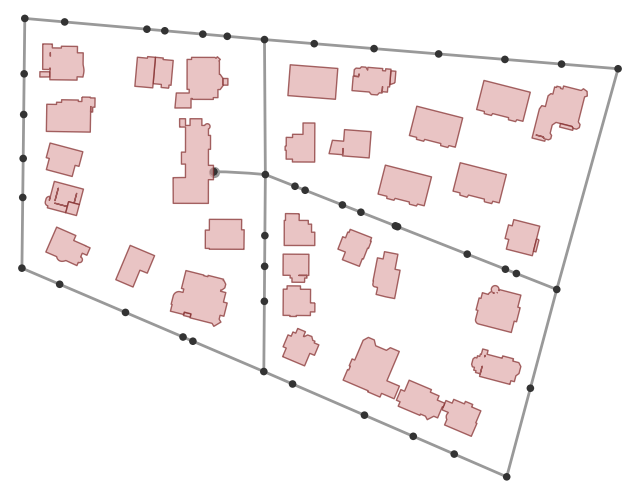

In [3]:
network = network.add_building_access()

# Plot street network graph and building footprints from GeoDataFrame
fig, ax = ox.plot_graph(network.street_graph, **plot_params)
network.buildings.plot(ax=ax, fc='#e0abab', ec='#802828', alpha=0.7)
plt.show()

## 5. Create minimum spanning tree

- Create Minimum Spanning Tree to calculate shortest possible heating network
- Create new graph containing Minimum Spanning Tree

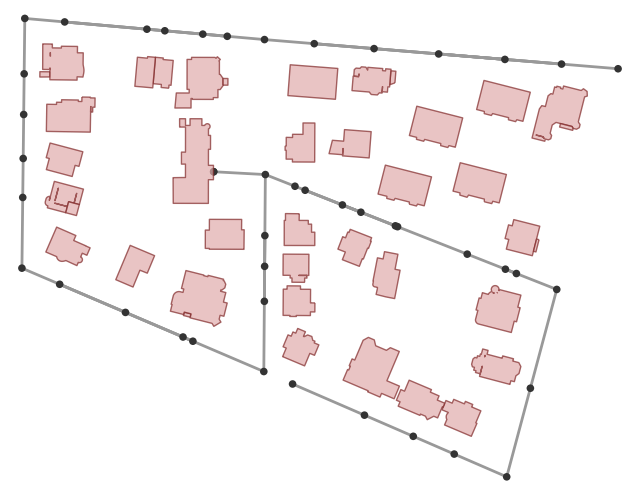

In [4]:
# Set supply node id
network.set_supply_node('B1180GregorMendelStrae22')

# Create minimum spanning tree
network = network.create_minimum_spanning_tree()

# Plot minimum spanning tree
fig, ax = ox.plot_graph(network.mst, **plot_params)
network.buildings.plot(ax=ax, fc='#e0abab', ec='#802828', alpha=0.7)
plt.show()

## 6. Convert CRS to true to area projection

In [5]:
# Function for converting crs of graph
def convert_crs_of_graph(graph, to_crs):
    nodes, edges = ox.graph_to_gdfs(graph)
    nodes = nodes.to_crs(to_crs)
    edges = edges.to_crs(to_crs)
   
    graph = ox.graph_from_gdfs(nodes, edges)
    return graph

from_crs = network.buildings.crs
to_crs = 'EPSG:31256'

# Convert graph    
#G_streets_access_31256 = convert_crs_of_graph(G_streets_access, 'EPSG:31256')
#G_mst_31256 = convert_crs_of_graph(G_mst, 'EPSG:31256')
network.street_graph = ox.project_graph(network.street_graph, to_crs=to_crs)
network.mst = ox.project_graph(network.mst, to_crs=to_crs)

# Convert gdf
network.buildings = network.buildings.to_crs(to_crs)

# Convert POINT elements of centroids in gdf
centroids = gpd.GeoSeries(network.buildings['centroid'], crs=from_crs)
network.buildings['centroid'] = centroids.to_crs(to_crs)

In [6]:
print(centroids.crs)

EPSG:4326


## 7. Setup UESgraphs network

In [7]:
# Import modules and functions
from shapely.geometry import Point
import uesgraphs as ug
import uesgraphs.utilities as ut
from uesgraphs.uesgraph import UESGraph
import uesgraphs.systemmodels.systemmodelheating as sysmh
import uesgraphs.systemmodels.utilities as sysut

## 5. Create UESGraph network

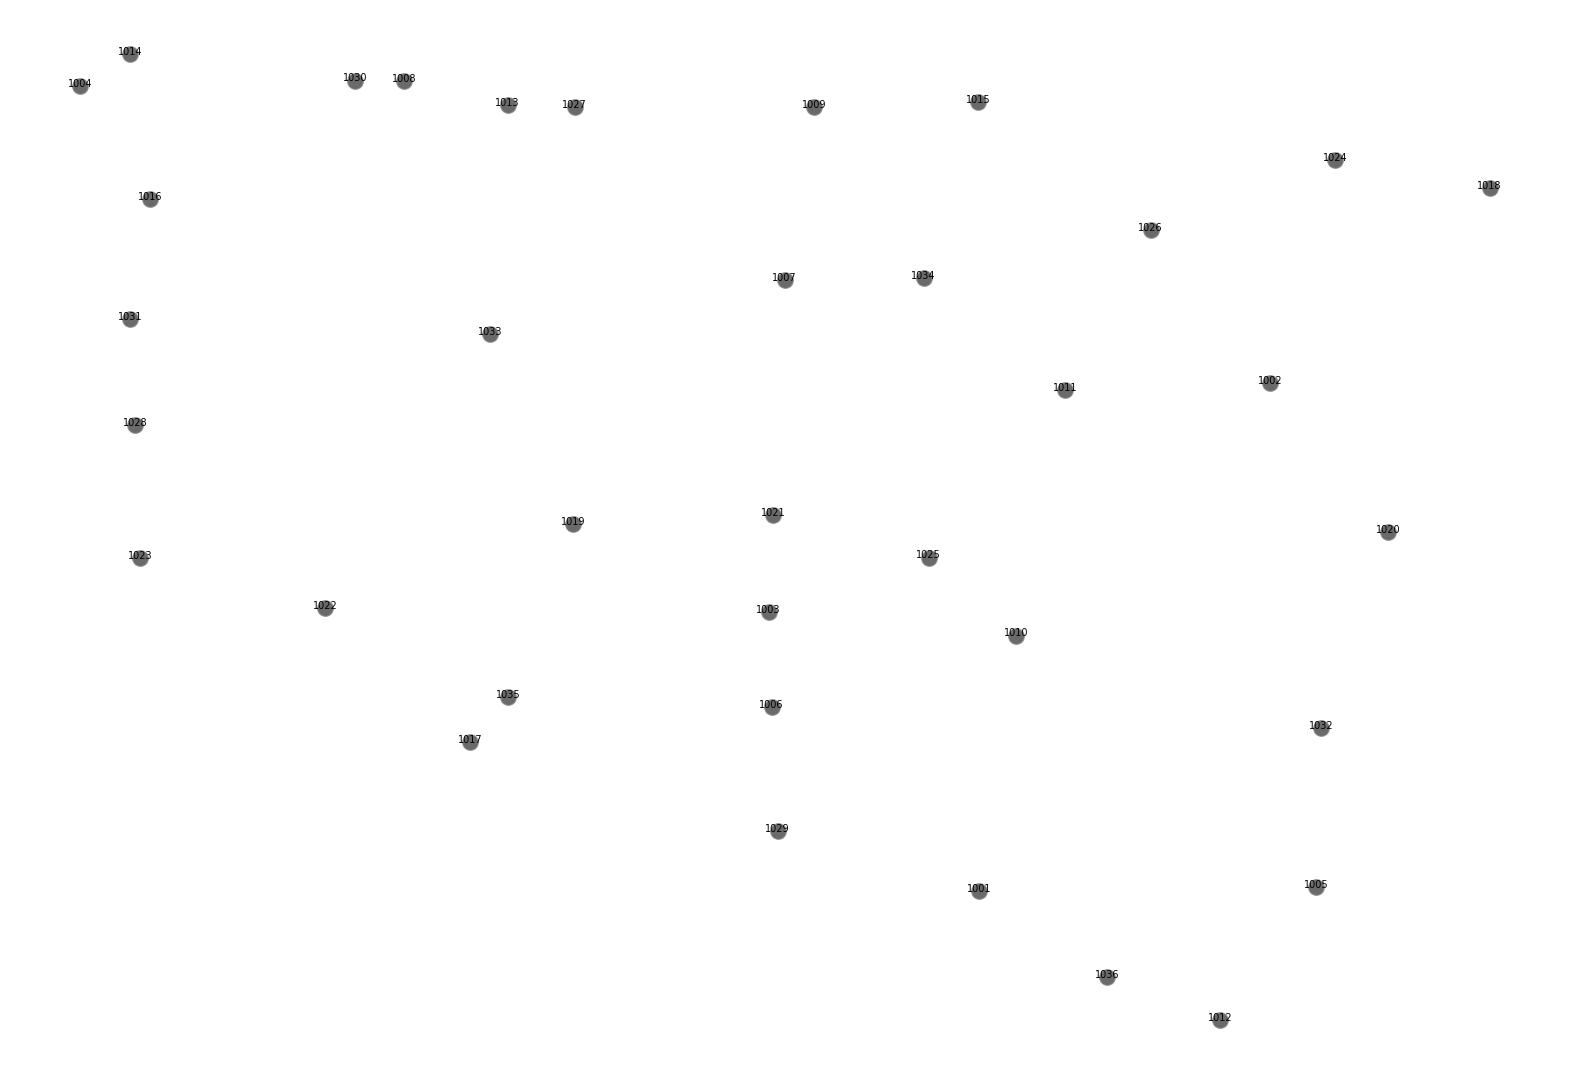

In [8]:
# Add buildings from gdf to UESGraphs
network = network.add_buildings_to_ues()

# Plot UESGraph
import uesgraphs as ug
vis = ug.Visuals(network.ues_graph)
fig = vis.show_network(labels='building', scaling_factor=5)

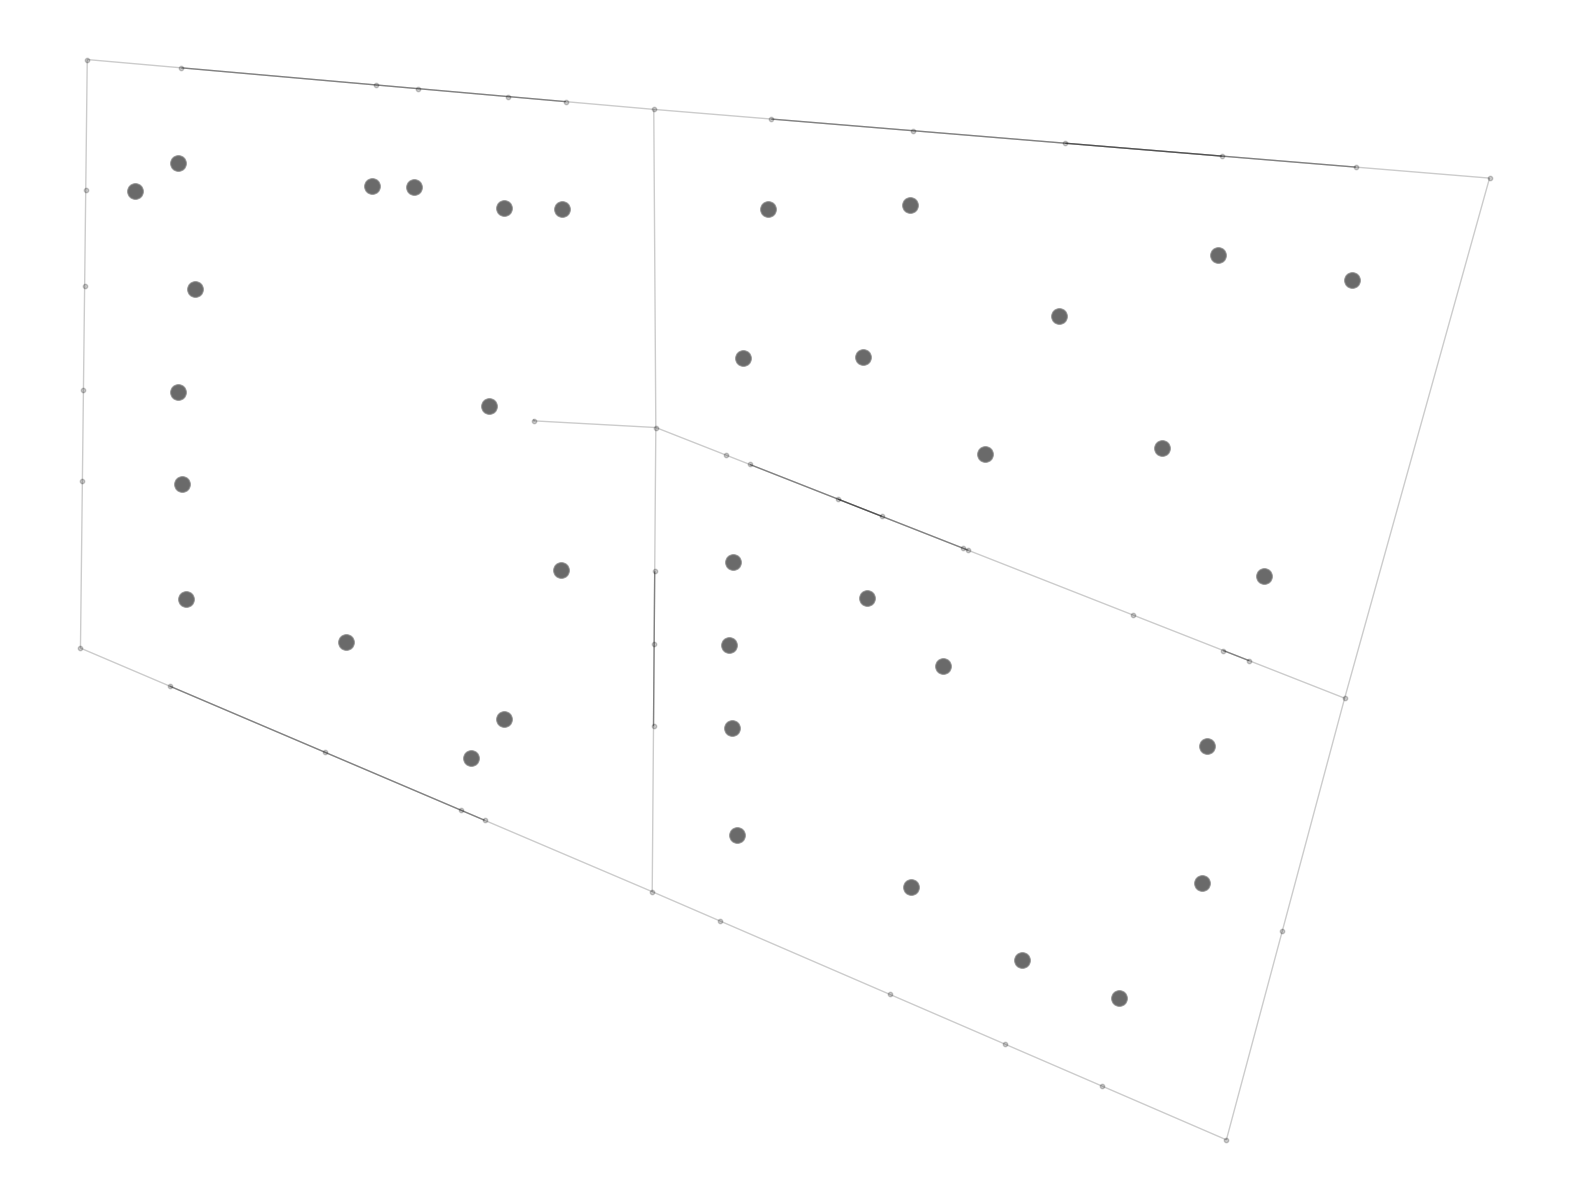

In [9]:
# Add streets from osmx to UESGraphs
network = network.add_street_network_to_ues()
vis = ug.Visuals(network.ues_graph)
fig = vis.show_network(scaling_factor=5)

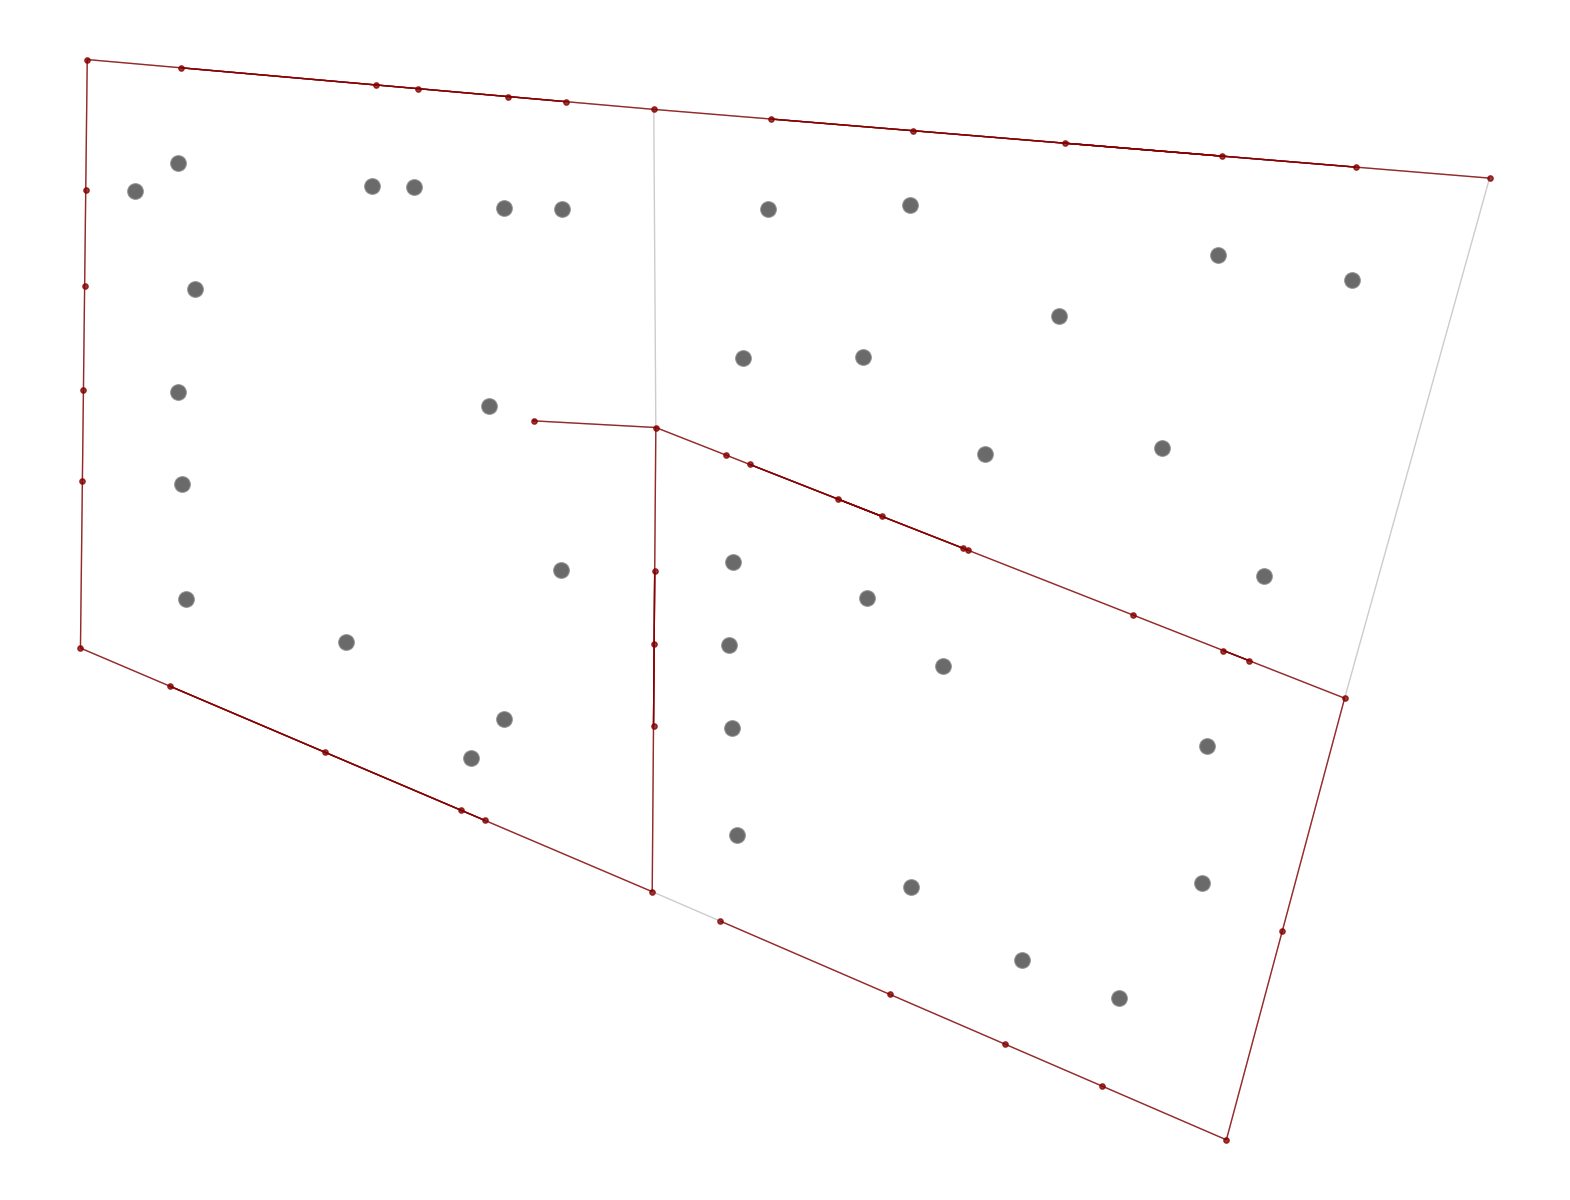

In [10]:
# Add heating network from osmnx to UESGraphs
network = network.add_heating_network_to_ues()
vis = ug.Visuals(network.ues_graph)
fig = vis.show_network(scaling_factor=5)

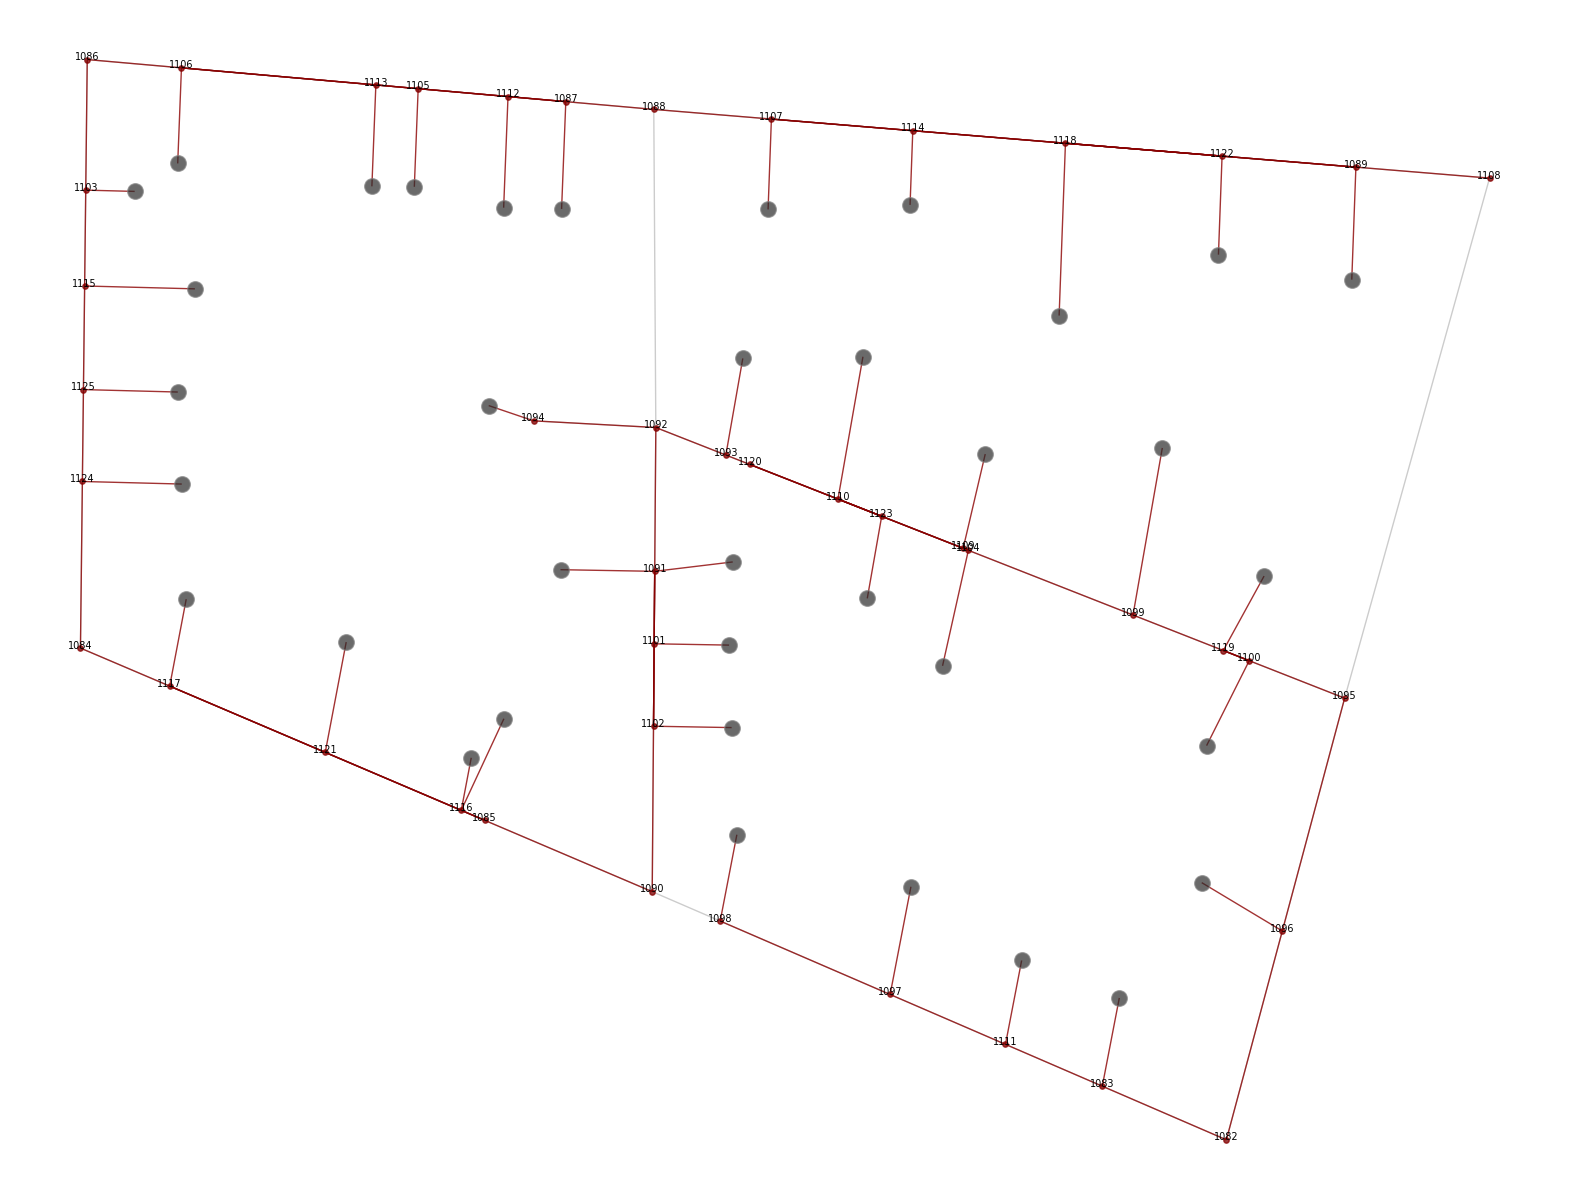

In [11]:
# Connect buildings to heating network
network = network.connect_buildings_to_heating_network()
vis = ug.Visuals(network.ues_graph)
fig = vis.show_network(labels='heat', scaling_factor=5)

## 6. Set supply building and pipe parameters

In [12]:
# Import Shapely
import shapely

# Set building as heating supply node
heating_supply_node = network.ues_graph.get_building_node("B1180GregorMendelStrae22")
network.ues_graph.nodes[heating_supply_node]['is_supply_heating'] = True

# Set pipe parameters
pipe_id = 0
for edge in network.ues_graph.edges:
    network.ues_graph.edges[edge]['pipeID'] = pipe_id
    pipe_id += 1
    network.ues_graph.edges[edge]['diameter'] = 0.150
    node_a = Point(network.ues_graph.nodes[edge[0]]['position'])
    node_b = Point(network.ues_graph.nodes[edge[1]]['position'])
    network.ues_graph.edges[edge]['length'] = round(shapely.distance(node_a, node_b),1)
    network.ues_graph.edges[edge]['name'] = "pipe"+str(pipe_id)
    network.ues_graph.edges[edge]['m_flow_nom'] = 2
    

## 7. Save network graph

In [13]:
# Set output path
graph_export_path = os.path.join(current_dir, 'output', 'uesgraph', 'pino')

# Create dir if not exists
if not os.path.exists(graph_export_path):
    os.makedirs(graph_export_path)
    
# Generate a JSON file of the UESGraph
network.ues_graph.to_json(
    path=graph_export_path,
    name="demo_pino",
    description="Pino example for uesmodels",
    all_data=True,
)

'c:\\Users\\dawo\\e7dw\\MAA\\simulations\\06_demo_new\\demo\\output\\uesgraph\\pino\\demo_pino.json'

## 8. Prepare UESgraph network for Modelica export

In [14]:
# Import TimeSeries Module
from dhc_sim.timeseries.loader import TimeseriesLoader

In [15]:
# Load temperature data
ts = TimeseriesLoader()

supply_temp_path = os.path.join(current_dir, 'data', 'timeseries', 'supply_temperature.csv')
ground_temp_path = os.path.join(current_dir, 'data', 'timeseries', 'ground_temperature.csv')

ts.load_ground_temperature(supply_temp_path)
ts.load_supply_temperature(ground_temp_path)

# Get supply temperature and ground temperature
T_supply = ts.supply_temp_data.temperature
T_ground = ts.ground_temp_data.temperature

# Set supply temperature and pressure for supply buildings
for node in network.ues_graph.nodelist_building:
    network.ues_graph.nodes[node]["p_supply"] = [3e5]  # Pa
    network.ues_graph.nodes[node]["T_supply"] = T_supply
    
# Set ground temperature
network.ues_graph.graph["T_ground"] = T_ground

# Additional data
dT_design = 30
for node in network.ues_graph.nodelist_building:
    if (
        not network.ues_graph.nodes[node]["is_supply_heating"]
        and not network.ues_graph.nodes[node]["is_supply_cooling"]
    ):
        network.ues_graph.nodes[node]["dT_design"] = dT_design
        # input heat set to 0, because heat demand is coming from teaser models
        network.ues_graph.nodes[node]['input_heat'] = 0
        
# write nominal heat load in graph (helper)
for idx, row in gdf.iterrows():
    name = row['name']
    heat_load = row['heat_load']

    node = network.ues_graph.get_building_node(name)
    network.ues_graph.nodes[node]['input_heat'] = [0.0, float(heat_load)]

fac = 1
dIns = 0.045
kIns = 0.05
for edge in network.ues_graph.edges():
    network.ues_graph.edges[edge[0], edge[1]]["fac"] = fac
    network.ues_graph.edges[edge[0], edge[1]]["dIns"] = dIns
    network.ues_graph.edges[edge[0], edge[1]]["kIns"] = kIns
    
# Convert positions to Modelica-ready coordinates
network.prepare_for_modelica(width_set=400)

## 9. Modelica model generation

In [16]:
def model_generation_pinola(ues_graph, dir_dest):
    """Run example model generation for Pinola network

    Parameters
    ----------
    dir_source : str
        Source directory with nodes.json
    dir_dest : str
        Directory to store generated models
    """
    #graph = UESGraph()

    # Import network from json input file using from_json function. Below the
    # network_type 'heating' is imported.
    #graph.from_json(path=dir_source, network_type="heating")
    ues_graph.graph["network_type"] = "heating"

    # To add data for model generation to the uesgraph the prepare_graph
    # funtion is used. There are thireen parameters available. Below the supply
    # temperature in K, supply pressure in Pa, return temperature in K,
    # return pressure in Pa, Design temperature difference over substation in K
    # and the nominal mass flow rate in kg/s are added to the graph.
    ues_graph = sysut.prepare_graph(
        graph=ues_graph,
        T_supply=[273.15 + 80],
        p_supply=6e5,
        T_return=273.15 + 50,
        p_return=2e5,
        dT_design=30,
        m_flow_nominal=40
    )

    # To generate a generic Modelica model the create_model function is used.
    # There are 21 parameters available.
    sysut.create_model(
        name="heat_network_open_loop_dT_var",
        save_at=dir_dest,
        graph=ues_graph,
        stop_time=603900,
        timestep=900,
        model_supply="AixLib.Fluid.DistrictHeatingCooling.Supplies.OpenLoop.SourceIdeal",
        model_demand="AixLib.Fluid.DistrictHeatingCooling.Demands.OpenLoop.VarTSupplyDp",
        model_pipe="AixLib.Fluid.FixedResistances.PlugFlowPipe",
        model_medium="AixLib.Media.Water",
        model_ground="t_ground_table",
        T_nominal=273.15 + 80,
        p_nominal=5e5,
    )

ues_graph_heating = network.ues_graph.create_subgraphs('heating')['default']

dest = os.path.join(current_dir, 'output', 'modelica')

dir_dest_m = os.path.abspath(os.path.join(dest))
if not os.path.exists(dir_dest_m):
    os.mkdir(dir_dest_m)

model_generation_pinola(ues_graph_heating, dir_dest_m)

dir_dest c:\Users\dawo\e7dw\MAA\simulations\06_demo_new\demo\output\modelica\Heat_network_open_loop_dT_var


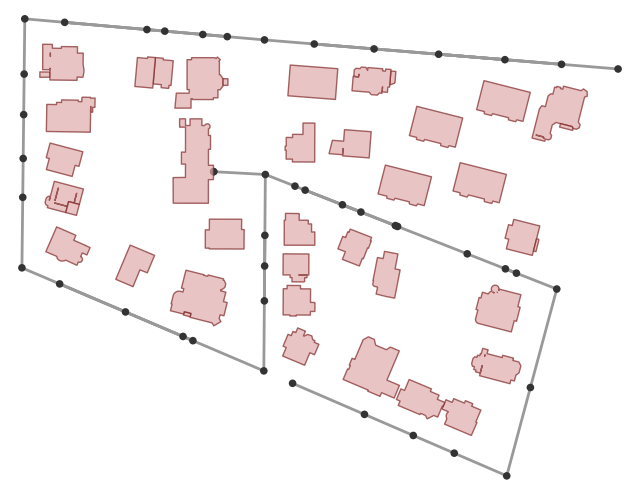

In [17]:
# Plot street network graph and building footprints from GeoDataFrame
fig, ax = ox.plot_graph(network.mst, **plot_params)
network.buildings.plot(ax=ax, fc='#e0abab', ec='#802828', alpha=0.7)
plt.show()

In [18]:
def convert_multidigraph_to_digraph(multidigraph, gdf, supply_node_id):
    # Erstelle einen neuen gerichteten Graphen
    digraph = nx.DiGraph()
    
    # Kopiere alle Nodes mit ihren Attributen
    for node, data in multidigraph.nodes(data=True):
        digraph.add_node(node, **data)
    
    # Erstelle einen ungerichteten Graph für den MST
    undirected = multidigraph.to_undirected()
    
    # Berechne alle kürzesten Pfade vom supply_node zu allen anderen Nodes
    paths = nx.single_source_shortest_path(undirected, supply_node_id)
    
    # Sortiere die Pfade nach ihrer Länge
    sorted_paths = sorted(paths.items(), key=lambda x: len(x[1]))
    
    # Dictionary zum Speichern der bereits hinzugefügten Kanten
    added_edges = set()
    
    # Füge die Kanten in der Reihenfolge der Pfade hinzu
    for target, path in sorted_paths:
        if target == supply_node_id:
            continue
        
        # Füge die Kanten entlang des Pfades hinzu
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            if (u, v) not in added_edges and (v, u) not in added_edges:
                # Füge die Kante nur hinzu, wenn sie noch nicht existiert
                digraph.add_edge(u, v)
                added_edges.add((u, v))
    
    return digraph

# Funktion zum Überprüfen der Kanten
def check_edges(digraph, supply_node_id):
    print(f"Anzahl der Kanten: {digraph.number_of_edges()}")
    print("\nKantenrichtungen:")
    
    # Überprüfe, ob alle Pfade vom supply_node ausgehen
    paths = nx.single_source_shortest_path(digraph, supply_node_id)
    all_correct = True
    
    for edge in digraph.edges():
        u, v = edge
        print(f"Kante von {u} nach {v}")
        
        # Überprüfe, ob die Kante Teil eines Pfades vom supply_node ist
        if v in paths and u in paths[v]:
            continue
        else:
            print(f"WARNUNG: Kante {u} -> {v} folgt nicht dem Fluss vom supply_node")
            all_correct = False
    
    print(f"\nAlle Flussrichtungen korrekt: {all_correct}")
    return all_correct






In [19]:
# Funktion zum Plotten des Graphen
def plot_directed_network(digraph):
    plt.figure(figsize=(12, 8))
    
    # Extrahiere die Positionen der Knoten
    pos = {node: (data['x'], data['y']) for node, data in digraph.nodes(data=True)}
    
    # Zeichne die Kanten mit deutlichen Pfeilen
    nx.draw_networkx_edges(digraph, pos,
                          edge_color='black',
                          arrows=True,
                          arrowsize=20,
                          arrowstyle='->',
                          width=1)
    
    # Zeichne die Knoten
    nx.draw_networkx_nodes(digraph, pos,
                          node_size=20,
                          node_color='red')
    
    plt.axis('off')
    plt.show()




In [20]:
# Verwendung
digraph = convert_multidigraph_to_digraph(mst, network.buildings, 'B1180GregorMendelStrae22')
check_edges(digraph, 'B1180GregorMendelStrae22')
plot_directed_network(digraph)


NameError: name 'mst' is not defined

In [ ]:
digraph
